In [52]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import copy
from pathlib import Path
from typing import Union, List, Literal, Dict, Callable, Tuple
import random

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torcheval.metrics import MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import torchvision.models as models
import torchvision.transforms as transform

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchsummary import summary

import warnings
warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger(__name__)
import hashlib

In [2]:
emory = pd.read_csv('emory_final.csv')
vini = pd.read_csv('vinidir_final.csv')

In [3]:
vini = vini.rename(columns={'image_paths':'image_path'})
emory = emory.rename(columns={'Image_Paths':'image_path'})

In [4]:
emory['image_path'] = emory['image_path'].str.replace(r'^../', '', regex=True)

In [5]:
vini['patient_id'] = vini['image_path'].apply(lambda x: x.split('/')[2])
emory['patient_id'] = emory['image_path'].apply(lambda x:x.split('/')[2])

In [6]:
emory_f = emory[(emory['asses']!='BIRADS 0') & (emory['asses']!='BIRADS 6')].reset_index(drop=True)

emory_f['asses'] = emory_f['asses'].str.replace(' ', '').str.upper()
vini['breast_birads'] = vini['breast_birads'].str.replace('-', '').str.replace(' ', '').str.upper()

# Rename columns for clarity and merge datasets
emory_f = emory_f.rename(columns={'asses': 'breast_birads', 'ViewPosition':'view',
                                  'ImageLateralityFinal':'laterality','tissueden':'breast_density'})

In [7]:
cc_mammo = vini[vini['view'] == 'CC'][['patient_id', 'image_path','view','laterality','breast_birads','breast_density']].reset_index(drop=True)
mlo_mammo = vini[vini['view'] == 'MLO'][['patient_id', 'image_path','view','laterality','breast_birads','breast_density']].reset_index(drop=True)

# Add sequence numbers within each laterality group for each patient
cc_mammo['seq_num'] = cc_mammo.groupby(['patient_id','laterality']).cumcount()
mlo_mammo['seq_num'] = mlo_mammo.groupby(['patient_id','laterality']).cumcount()

# Rename columns to distinguish left and right
cc_mammo = cc_mammo.rename(columns={
    'image_path': 'image_path_CC',
    'breast_birads': 'breast_birads_CC',
    'breast_density':'breast_density_CC'
})
mlo_mammo = mlo_mammo.rename(columns={
    'image_path': 'image_path_MLO',
    'breast_birads': 'breast_birads_MLO',
    'breast_density':'breast_density_MLO'
})

vini_merged = pd.merge(cc_mammo,mlo_mammo,on=['patient_id', 'seq_num'])


In [8]:
cc_mammo = emory_f[emory_f['view'] == 'CC'][['patient_id', 'image_path','view','laterality','breast_birads','breast_density']].reset_index(drop=True)
mlo_mammo = emory_f[emory_f['view'] == 'MLO'][['patient_id', 'image_path','view','laterality','breast_birads','breast_density']].reset_index(drop=True)

# Add sequence numbers within each laterality group for each patient
cc_mammo['seq_num'] = cc_mammo.groupby(['patient_id','laterality']).cumcount()
mlo_mammo['seq_num'] = mlo_mammo.groupby(['patient_id','laterality']).cumcount()

# Rename columns to distinguish left and right
cc_mammo = cc_mammo.rename(columns={
    'image_path': 'image_path_CC',
    'breast_birads': 'breast_birads_CC',
    'breast_density': 'breast_density_CC'
})
mlo_mammo = mlo_mammo.rename(columns={
    'image_path': 'image_path_MLO',
    'breast_birads': 'breast_birads_MLO',
    'breast_density': 'breast_density_MLO'
})

emory_merged = pd.merge(cc_mammo,mlo_mammo,on=['patient_id', 'seq_num'])


In [9]:
data = pd.concat([
    vini_merged,
    emory_merged
], axis=0).reset_index(drop=True)
data = data[data['breast_birads_CC']==data['breast_birads_MLO']].reset_index(drop=True)

In [10]:
data['breast_birads_CC'].value_counts(), data['breast_birads_MLO'].value_counts()

(breast_birads_CC
 BIRADS1    18362
 BIRADS2     4764
 BIRADS3      866
 BIRADS4      717
 BIRADS5      235
 Name: count, dtype: int64,
 breast_birads_MLO
 BIRADS1    18362
 BIRADS2     4764
 BIRADS3      866
 BIRADS4      717
 BIRADS5      235
 Name: count, dtype: int64)

In [14]:
# Filter out rows with BIRADS5 in either breast_birads_CC or breast_birads_MLO
filtered_data = data[~data['breast_birads_CC'].isin(['BIRADS5']) & ~data['breast_birads_MLO'].isin(['BIRADS5'])]

# Group by both breast_birads_CC and breast_birads_MLO to ensure balanced sampling across classes
# Use .apply with .sample to get 700 samples for each group
# balanced_data = data.groupby(['breast_birads_CC'], group_keys=False).apply(
#     lambda x: x.sample(n=min(balanced_data.breast_birads_CC.min(), len(x)), random_state=42)
# )

balanced_data = filtered_data.groupby('breast_birads_CC', group_keys=False).apply(
    lambda x: x.sample(n=min(1000, len(x)), random_state=42)
)


balanced_data = balanced_data.reset_index(drop=True)
balanced_data['breast_birads_CC'].value_counts(), balanced_data['breast_birads_MLO'].value_counts()

(breast_birads_CC
 BIRADS1    1000
 BIRADS2    1000
 BIRADS3     866
 BIRADS4     717
 Name: count, dtype: int64,
 breast_birads_MLO
 BIRADS1    1000
 BIRADS2    1000
 BIRADS3     866
 BIRADS4     717
 Name: count, dtype: int64)

## DATA PREPARATION

In [15]:
# Define the mapping dictionary
birads_mapping = {
    'BIRADS1': 0,
    'BIRADS2': 1,
    'BIRADS3': 2,
    'BIRADS4': 3,
    'BIRADS5': 4
}

# Map the breast_birads columns to numeric identifiers
balanced_data['breast_birads_CC'] = balanced_data['breast_birads_CC'].map(birads_mapping)
balanced_data['breast_birads_MLO'] = balanced_data['breast_birads_MLO'].map(birads_mapping)
balanced_data.head()

,patient_id,image_path_CC,view_x,laterality_x,breast_birads_CC,breast_density_CC,seq_num,image_path_MLO,view_y,laterality_y,breast_birads_MLO,breast_density_MLO
0,61f3d797233b229db610017bd62dc862,vinidr-mammogram-dataset/images_png/61f3d79723...,CC,R,0,DENSITY C,0,vinidr-mammogram-dataset/images_png/61f3d79723...,MLO,R,0,DENSITY C
1,164f0e6a330b6e498aea7032530b49f0,vinidr-mammogram-dataset/images_png/164f0e6a33...,CC,R,0,DENSITY C,0,vinidr-mammogram-dataset/images_png/164f0e6a33...,MLO,R,0,DENSITY C
2,10575833,emory/images_png/10575833/1.2.844.113689.27508...,CC,R,0,DENSITY A,4,emory/images_png/10575833/1.2.847.113684.27508...,MLO,L,0,DENSITY A
3,caa4eba9b95ac07e8063ff87e90b60ee,vinidr-mammogram-dataset/images_png/caa4eba9b9...,CC,R,0,DENSITY D,0,vinidr-mammogram-dataset/images_png/caa4eba9b9...,MLO,L,0,DENSITY D
4,63daec7e094feedd1d827bf750a144e8,vinidr-mammogram-dataset/images_png/63daec7e09...,CC,L,0,DENSITY D,0,vinidr-mammogram-dataset/images_png/63daec7e09...,MLO,R,0,DENSITY D


In [ ]:
import os
import cv2
import pandas as pd

def validate_images(dataset_df, image_columns):
    valid_indices = []
    invalid_paths = []

    for idx, row in tqdm(dataset_df.iterrows(), desc="Processing dataset rows"):
        is_valid = True
        for col in image_columns:
            image_path = row[col]
            if not os.path.exists(image_path):
                print(f"Missing file: {image_path}")
                invalid_paths.append(image_path)
                is_valid = False
                continue
            
            # Try to read the image
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Corrupted file: {image_path}")
                invalid_paths.append(image_path)
                is_valid = False
        
        if is_valid:
            valid_indices.append(idx)

    # Return a filtered dataset and log invalid paths
    valid_dataset = dataset_df.iloc[valid_indices].reset_index(drop=True)
    return valid_dataset, invalid_paths

cdataset, invalidpaths = validate_images(balanced_data, ['image_path_CC','image_path_MLO'])

In [18]:
cdataset

,patient_id,image_path_CC,view_x,laterality_x,breast_birads_CC,breast_density_CC,seq_num,image_path_MLO,view_y,laterality_y,breast_birads_MLO,breast_density_MLO
0,61f3d797233b229db610017bd62dc862,vinidr-mammogram-dataset/images_png/61f3d79723...,CC,R,0,DENSITY C,0,vinidr-mammogram-dataset/images_png/61f3d79723...,MLO,R,0,DENSITY C
1,164f0e6a330b6e498aea7032530b49f0,vinidr-mammogram-dataset/images_png/164f0e6a33...,CC,R,0,DENSITY C,0,vinidr-mammogram-dataset/images_png/164f0e6a33...,MLO,R,0,DENSITY C
2,10575833,emory/images_png/10575833/1.2.844.113689.27508...,CC,R,0,DENSITY A,4,emory/images_png/10575833/1.2.847.113684.27508...,MLO,L,0,DENSITY A
3,caa4eba9b95ac07e8063ff87e90b60ee,vinidr-mammogram-dataset/images_png/caa4eba9b9...,CC,R,0,DENSITY D,0,vinidr-mammogram-dataset/images_png/caa4eba9b9...,MLO,L,0,DENSITY D
4,63daec7e094feedd1d827bf750a144e8,vinidr-mammogram-dataset/images_png/63daec7e09...,CC,L,0,DENSITY D,0,vinidr-mammogram-dataset/images_png/63daec7e09...,MLO,R,0,DENSITY D
...,...,...,...,...,...,...,...,...,...,...,...,...
3570,b7357809d8e2bb3ad964b4c2c53e6c7e,vinidr-mammogram-dataset/images_png/b7357809d8...,CC,L,3,DENSITY C,0,vinidr-mammogram-dataset/images_png/b7357809d8...,MLO,L,3,DENSITY C
3571,709ecc90dad40571fd26e3270de97966,vinidr-mammogram-dataset/images_png/709ecc90da...,CC,R,3,DENSITY C,0,vinidr-mammogram-dataset/images_png/709ecc90da...,MLO,R,3,DENSITY C
3572,5e738b21ece161aa495b59fee9c11455,vinidr-mammogram-dataset/images_png/5e738b21ec...,CC,L,3,DENSITY C,2,vinidr-mammogram-dataset/images_png/5e738b21ec...,MLO,L,3,DENSITY C
3573,4ccad6b7e7b7a4e492b0fd56b5bef883,vinidr-mammogram-dataset/images_png/4ccad6b7e7...,CC,L,3,DENSITY C,0,vinidr-mammogram-dataset/images_png/4ccad6b7e7...,MLO,L,3,DENSITY C


In [19]:
from sklearn.model_selection import train_test_split

t, test = train_test_split(cdataset, test_size=0.2, stratify=cdataset['breast_birads_CC'])
train, val = train_test_split(t, test_size=0.2, stratify=t['breast_birads_CC'])

In [20]:
train, val, test = train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

In [21]:
def display_grid(data):
    idx = random.sample(range(data.shape[0]), 4)
    
    # Set the plot size
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 10))

    for i, row in enumerate(data.iloc[idx].itertuples()):
        # Build image path
        img_file_paL = row.image_path_CC
        img_file_paR = row.image_path_MLO

        # Open and show image
        imgL = Image.open(img_file_paL)
        imgR = Image.open(img_file_paR)
        try:
            axes[i, 0].imshow(imgL, cmap='gray')
            axes[i, 1].imshow(imgR, cmap='gray')
        except Exception as e:
            print(f"Cannot Display {img_file_paL} & {img_file_paR}, because of error:{e}")
        
        axes[i, 0].set_title(f"{i} {row.breast_birads_CC}")
        axes[i, 1].set_title(f"{i} {row.breast_birads_MLO}")
    
    plt.tight_layout()
    plt.show()



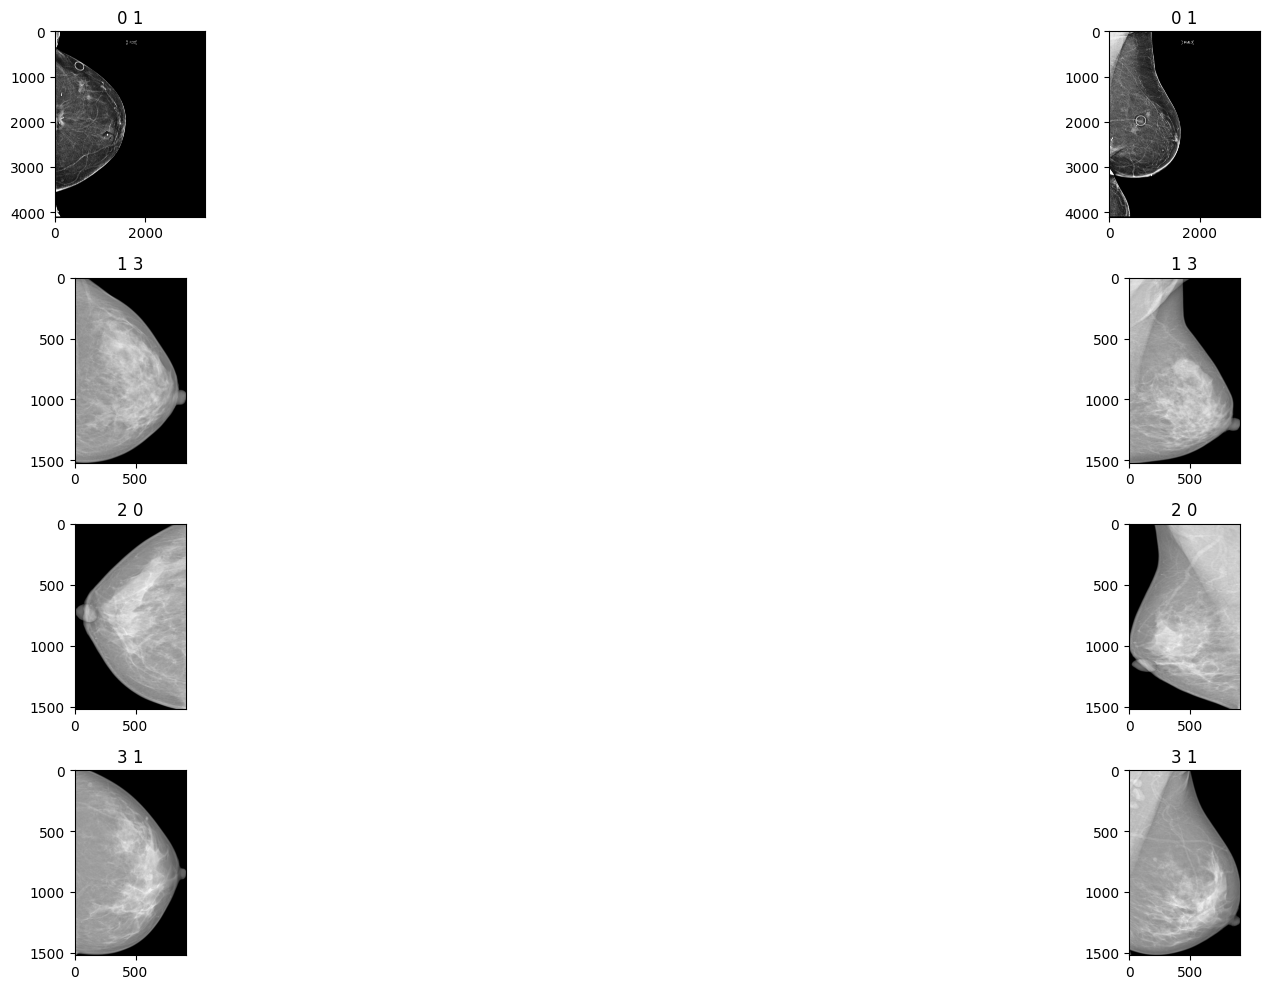

In [22]:
display_grid(train)

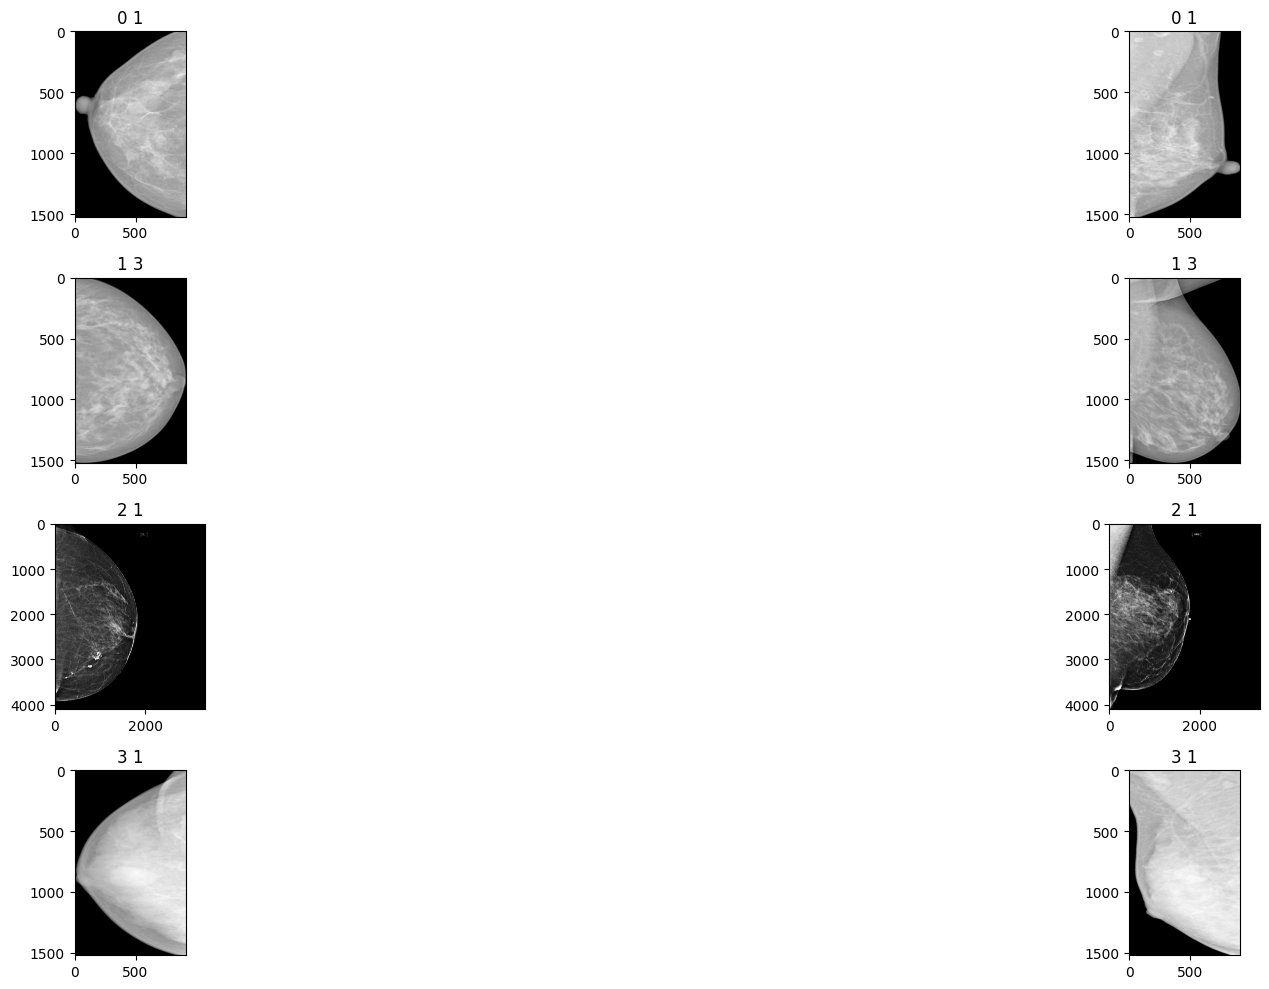

In [23]:
display_grid(val)

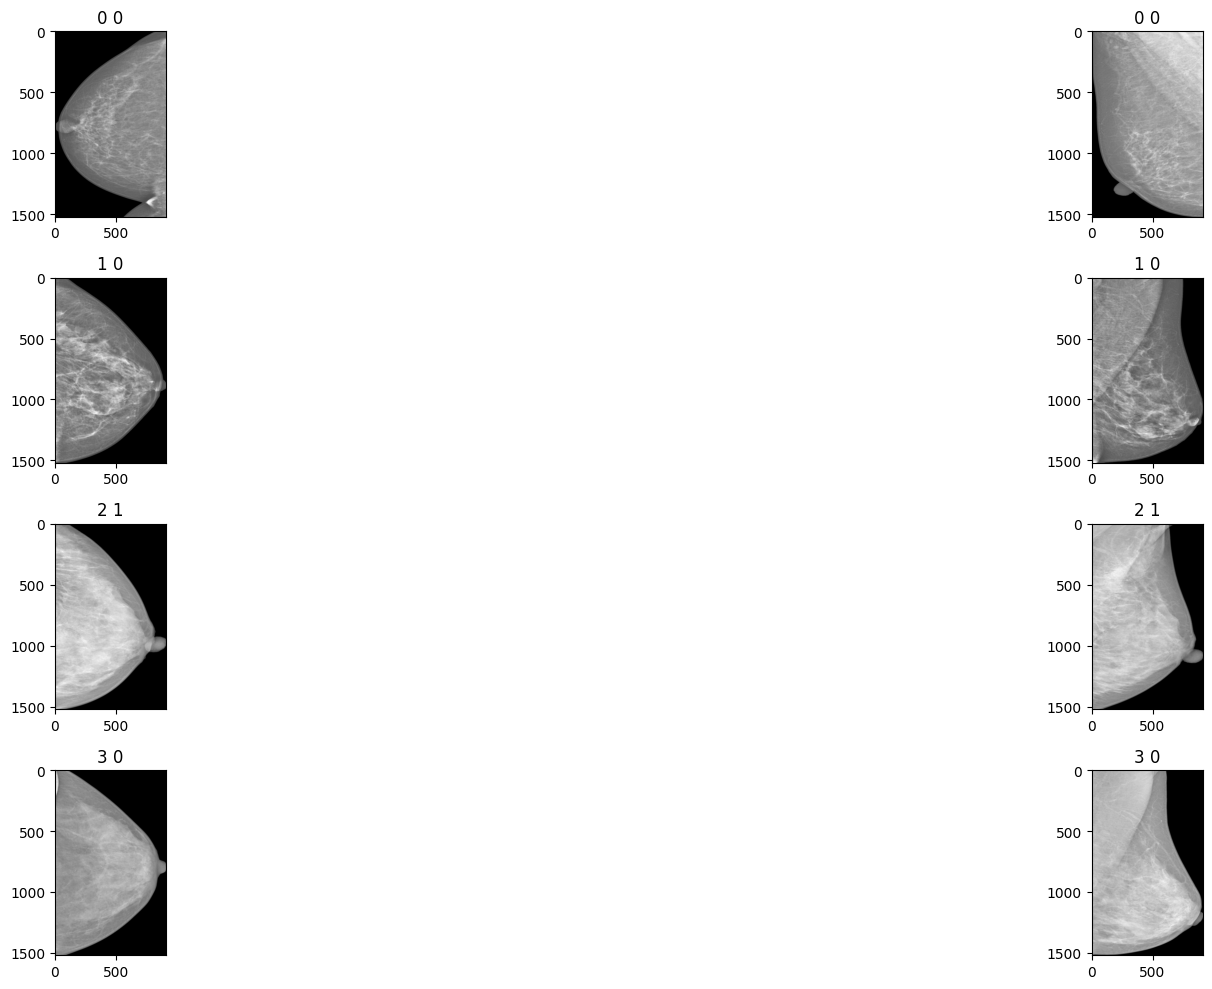

In [24]:
display_grid(test)

In [25]:
import torch
import cv2

def torch_CountUpContinuingOnes(b_arr):
    left = torch.arange(len(b_arr))
    left[b_arr > 0] = 0
    left = torch.cummax(left, dim=-1)[0]

    rev_arr = torch.flip(b_arr, [-1])
    right = torch.arange(len(rev_arr))
    right[rev_arr > 0] = 0
    right = torch.cummax(right, dim=-1)[0]
    right = len(rev_arr) - 1 - torch.flip(right, [-1])

    return right - left - 1

def torch_ExtractBreast_with_padding_single_side(img_ori, target_size=(512, 512), padding=1):
    # Detect background and set to zero
    img = torch.where(img_ori <= 40, torch.zeros_like(img_ori), img_ori)
    height, _ = img.shape

    # Extract the main breast region (same as before)
    y_a = height // 2 + int(height * 0.4)
    y_b = height // 2 - int(height * 0.4)
    b_arr = img[y_b:y_a].to(torch.float32).std(dim=0) != 0
    continuing_ones = torch_CountUpContinuingOnes(b_arr)
    col_ind = torch.where(continuing_ones == continuing_ones.max())[0]
    img = img[:, col_ind]

    _, width = img.shape
    x_a = width // 2 + int(width * 0.4)
    x_b = width // 2 - int(width * 0.4)
    b_arr = img[:, x_b:x_a].to(torch.float32).std(dim=1) != 0
    continuing_ones = torch_CountUpContinuingOnes(b_arr)
    row_ind = torch.where(continuing_ones == continuing_ones.max())[0]
    breast_region = img_ori[row_ind][:, col_ind]

    # Resize the extracted breast region while maintaining the aspect ratio
    breast_height, breast_width = breast_region.shape
    aspect_ratio = breast_width / breast_height

    # Define target dimensions based on aspect ratio
    if aspect_ratio > 1:
        # Wider than tall
        new_width = target_size[1] - padding
        new_height = int(new_width / aspect_ratio)
    else:
        # Taller than wide
        new_height = target_size[0] - padding
        new_width = int(new_height * aspect_ratio)

    resized_breast = cv2.resize(breast_region.cpu().numpy(), (new_width, new_height))
    resized_breast = torch.from_numpy(resized_breast)

    # Determine which side has lower intensity
    pad_x = target_size[1] - new_width
    pad_y = target_size[0] - new_height

    # Initialize offsets
    x_offset = 0
    y_offset = 0

    # Decide padding side for x-axis
    if pad_x > 0:
        left_intensity = resized_breast[:, 0].mean()
        right_intensity = resized_breast[:, -1].mean()
        if left_intensity < right_intensity:
            # Pad on the left side
            x_offset = pad_x
        else:
            # Pad on the right side
            x_offset = 0

    # Decide padding side for y-axis
    if pad_y > 0:
        top_intensity = resized_breast[0, :].mean()
        bottom_intensity = resized_breast[-1, :].mean()
        if top_intensity < bottom_intensity:
            # Pad on the top side
            y_offset = pad_y
        else:
            # Pad on the bottom side
            y_offset = 0

    # Create a padded image with the target size and place the resized breast region
    padded_img = torch.zeros(target_size, dtype=resized_breast.dtype)
    padded_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_breast

    return padded_img

def resize_with_padding_vini(img_np, target_size=(512, 512), padding=1):
    # Convert image to a torch tensor if not already
    img_torch = torch.from_numpy(img_np).to(torch.float32)

    # Ensure the breast region fits within a consistent scale
    breast_height, breast_width = img_torch.shape
    aspect_ratio = breast_width / breast_height

    # Define target dimensions based on aspect ratio
    if aspect_ratio > 1:
        # Wider than tall
        new_width = target_size[1] - padding
        new_height = int(new_width / aspect_ratio)
    else:
        # Taller than wide
        new_height = target_size[0] - padding
        new_width = int(new_height * aspect_ratio)
    
    # Resize while maintaining the aspect ratio
    resized_breast = cv2.resize(img_np, (new_width, new_height))
    resized_breast = torch.from_numpy(resized_breast)

     # Determine which side has lower intensity
    pad_x = target_size[1] - new_width
    pad_y = target_size[0] - new_height

    # Initialize offsets
    x_offset = 0
    y_offset = 0

    # Decide padding side for x-axis
    if pad_x > 0:
        left_intensity = resized_breast[:, 0].mean()
        right_intensity = resized_breast[:, -1].mean()
        if left_intensity < right_intensity:
            # Pad on the left side
            x_offset = pad_x
        else:
            # Pad on the right side
            x_offset = 0

    # Decide padding side for y-axis
    if pad_y > 0:
        top_intensity = resized_breast[0, :].mean()
        bottom_intensity = resized_breast[-1, :].mean()
        if top_intensity < bottom_intensity:
            # Pad on the top side
            y_offset = pad_y
        else:
            # Pad on the bottom side
            y_offset = 0

    # Create a padded image with the target size and place the resized breast region
    padded_img = torch.zeros(target_size, dtype=resized_breast.dtype)
    padded_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_breast

    return padded_img


In [26]:
def resize_image(image_path, size=(512, 512)):
    if os.path.exists(image_path):
        img_np = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Check if the image was read successfully
        if img_np is None:
            logging.error(f"Failed to load image at {image_path}.")
            return None  # You could return a default image or raise an error
            
        if 'emory' in image_path:
            img_torch = torch.from_numpy(img_np).to(torch.float32)
            img_torch = mean_variance_normalization(img_torch)

            # Extract the breast region
            breast_region = torch_ExtractBreast_with_padding_single_side(img_torch)

            # Convert the result back to a NumPy array for visualization or further processing
            breast_region_np = breast_region.cpu().numpy().astype(np.uint8)
            # breast_region_np = apply_clahe(breast_region_np)
            breast_region_rgb = np.repeat(breast_region_np[:, :, np.newaxis], 3, axis=2)

            # Convert the NumPy array to a PIL image for compatibility with transforms
            breast_region_pil = Image.fromarray(breast_region_rgb)
        else:
            # img_torch = torch.from_numpy(img_np).to(torch.float32)
            # # Normalize the image
            img_np = mean_variance_normalization(img_np)
            breast_region_np = resize_with_padding_vini(img_np)
            # Convert the result back to a NumPy array for visualization or further processing
            breast_region_np = breast_region_np.cpu().numpy().astype(np.uint8)
            # breast_region_np = apply_clahe(breast_region_np)

            breast_region_rgb = np.repeat(breast_region_np[:, :, np.newaxis], 3, axis=2)

            # Convert the NumPy array to a PIL image for compatibility with transforms
            breast_region_pil = Image.fromarray(breast_region_rgb)

        img = breast_region_pil
        return img
    else:
        logging.error(f"Image path does not exist: {image_path}")
        return None


In [27]:
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(image)
    return equalized_img

def mean_variance_normalization(img_torch):
    img_min, img_max = img_torch.min(), img_torch.max()
    img_torch = (img_torch - img_min) / (img_max - img_min) * 255
    return img_torch



In [28]:
class NumpyToTensor(A.ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1.0):
        super().__init__(always_apply, p)

    def apply(self, image, **params):
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
        return image

train_transform = A.Compose([
    A.RandomScale(scale_limit=(-0.2, 0.2), p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=0, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Resize(height=256, width=256),
    A.Normalize([0.5],[0.5]),
    NumpyToTensor()
])

val_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.Normalize([0.5],[0.5]),
    NumpyToTensor()
])

In [29]:
# train_transforms = transform.Compose([
#     transform.Resize(256),
#     transform.CenterCrop(224),
#     transform.RandomHorizontalFlip(),
#     transform.RandomRotation(10),
#     transform.RandomGrayscale(),
#     transform.RandomAffine(translate=(0.05,0.05), degrees=0),
#     transform.ToTensor(),
#     transform.Normalize([0.5], [0.5])

# ])

# val_transforms = transform.Compose([
#     transform.Resize(256),
#     transform.CenterCrop(224),
#     transform.ToTensor(),
#     transform.Normalize([0.5], [0.5])
# ])


In [30]:
class CustomDataset(Dataset):
    def __init__(self, data_set: pd.DataFrame, transforms=None):
        self.dataset = data_set
        self.transform = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        dict_data = {}
        is_synth = [False, False]
        
        # Retrieve paths
        label_1 = int(self.dataset['breast_birads_CC'].iloc[idx])
        label_2 = int(self.dataset['breast_birads_MLO'].iloc[idx])
        image_path_1 = self.dataset['image_path_CC'].iloc[idx]
        image_path_2 = self.dataset['image_path_MLO'].iloc[idx]
        
        img_1 = resize_image(image_path_1)
        img_2 = resize_image(image_path_2)
        
        if img_1 is None:
            logger.warning(f"Image loading failed for index {idx}. Using fallback image.")
            img_1 = resize_image(self.dataset['image_path_CC'].iloc[max(0, idx - 1)])
        if img_2 is None:
            logger.warning(f"Image loading failed for index {idx}. Using fallback image.")
            img_2 = resize_image(self.dataset['image_path_MLO'].iloc[max(0, idx - 1)])
            
        # Apply transformations if images are loaded
        if img_1:
            img_1 = np.array(img_1)
            img_1 = self.transform(image=img_1)['image'] if self.transform else img_1
        if img_2:
            img_2 = np.array(img_2)
            img_2 = self.transform(image=img_2)['image'] if self.transform else img_2

        # Store images, labels, and synthetic tracker
        dict_data['images'] = {'img1': img_1, 'img2': img_2}
        dict_data['labels'] = {'label1': torch.tensor(label_1, dtype=torch.float32),
                               'label2': torch.tensor(label_2, dtype=torch.float32)}
        dict_data['is_synth'] = is_synth
        
        return dict_data

In [31]:
train_dataset = CustomDataset(data_set=train, transforms=train_transform)
val_dataset = CustomDataset(data_set=val, transforms=val_transform)
test_dataset = CustomDataset(data_set =test, transforms=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

loaders = {
    'train': train_dataloader,
    'val': val_dataloader
} 

In [32]:
dact = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5058824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745099].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.3647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.67058825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6392157..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.91372555].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117648].
Clipping input data to th

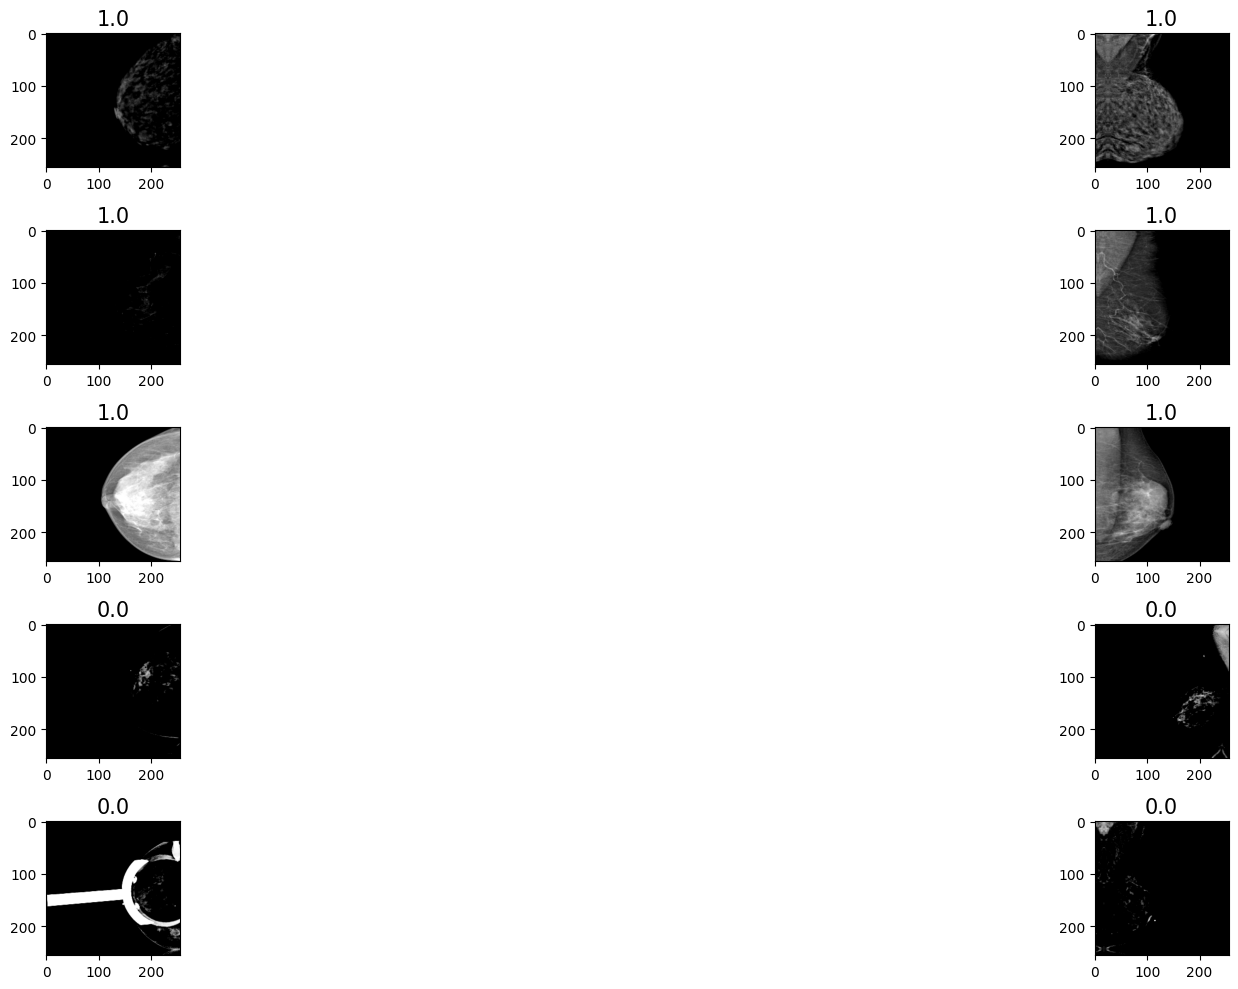

In [33]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30,10))

for i in range(5):
    axs[i,0].imshow(dact['images']['img1'][i].numpy().transpose((1,2,0)))
    axs[i,1].imshow(dact['images']['img2'][i].numpy().transpose((1,2,0)))
    axs[i,0].set_title(f"{dact['labels']['label1'][i].item()}", size=15)
    axs[i,1].set_title(f"{dact['labels']['label2'][i].item()}", size=15)

plt.tight_layout()
plt.show()
    

In [34]:
def set_seed(seed : int = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [35]:
class Efficient(nn.Module):
    def __init__(self, base_model, num_classes:int=5):
        super(Efficient, self).__init__()
        self.model = base_model
        # self.model = EfficientNet.from_pretrained("efficientnet-b0")
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1280),
            nn.Linear(1280, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, num_classes),
        )
        
    def forward(self, img):
        x = self.model.extract_features(img)
        x = self.pool(x)
        x = x.view(-1, 1280)
        x = self.classifier(x)
        return x


class EnsembleNet(nn.Module):
    def __init__(self, base_models):
        super().__init__()
        
        self.model_cc = base_models[0]
        self.model_mlo = base_models[1]
        
    def forward(self, images):
        x_cc = self.model_cc(images['img1'])
        x_mlo = self.model_mlo(images['img2'])
                
        prediction = (x_cc + x_mlo) / 2
        return prediction

In [36]:
class GeneralizedDiceLoss(torch.nn.Module):
    def __init__(self, use_multiclass=True):
        super(GeneralizedDiceLoss, self).__init__()
        self.multiclass = use_multiclass

    def forward(self, inputs, targets, smooth=1):
        # comment out if your model contains a softmax or equivalent activation layer
        if self.multiclass:
            inputs = F.softmax(inputs, dim=1)
        else:
            inputs = F.sigmoid(inputs) 
            
        targets = torch.nn.functional.one_hot(targets, num_classes=inputs.shape[1])
        # targets = targets.permute(0, 3, 1, 2)  # Rearrange to match inputs (batch, classes, height, width)

        # flatten label and prediction tensors
        inputs = inputs.view(inputs.shape[0], inputs.shape[1], -1)
        targets = targets.view(targets.shape[0], targets.shape[1], -1)

        # intersection is equivalent to True Positive count
        intersection = torch.sum(inputs * targets, dim=2)
        
        # compute the Dice coefficient for each class
        dice_scores = (2. * intersection + smooth) / (torch.sum(inputs, dim=2) + torch.sum(targets, dim=2) + smooth)

        # average the Dice scores over all classes
        dice_loss = 1 - torch.mean(dice_scores, dim=1)

        return dice_loss.mean()

In [37]:
def get_loss_coefficients(synthetic_proportion):
    """
    Calculate loss coefficients based on proportion of synthetic data.
    
    Args:
        synthetic_proportion (float): Proportion of synthetic data (0.0 to 1.0)
    
    Returns:
        tuple: (original_coefficient, synthetic_coefficient)
    """
    k = 0.8  # scaling factor
    original_coef = 1.0
    synthetic_coef = k * (synthetic_proportion / (1 + synthetic_proportion))
    
    return original_coef, synthetic_coef

In [38]:
def run_epoch(
    model: nn.Module, 
    dataloader: DataLoader, 
    criterion: Callable, 
    optimizer: optim.Optimizer = None,
    scaler: torch.cuda.amp.GradScaler = None, 
    phase: str = 'train', 
    synth_prop=0.25, 
    num_classes=3, 
    device='cuda') -> dict:
    """
    Runs a single epoch of training or validation with mixed precision.

    Args:
        model: The model being trained or validated.
        dataloader: The dataloader for training or validation.
        criterion: Loss function.
        optimizer: Optimizer (if phase is 'train').
        scaler: GradScaler for mixed precision training.
        phase: Specifies 'train' or 'val' phase.
        device: The device to run the model on.

    Returns:
        A dictionary containing loss and accuracy metrics.
    """
    
    running_loss, running_corrects, ns = 0.0, 0, 0
    precision_metric = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    recall_metric = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
    
    for batch in tqdm(dataloader, desc=f"{phase.capitalize()} Epoch"):
        images, labels = batch['images'], batch['labels']
        images = {k: v.to(device) for k, v in images.items()}
        label1, label2 = labels['label1'].to(device), labels['label2'].to(device)
        y = torch.max(label1, label2).long()
        
        # if phase=="train":
#             combined_is_synth = batch['is_synth'][0] | batch['is_synth'][1]
#             true_indices_combined = torch.where(combined_is_synth)[0]
#             # synth_labels = y[true_indices_combined]
#             orig_labels = y[~true_indices_combined]
        
        
        with torch.cuda.amp.autocast():  # Enable mixed precision
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # loss = criterion(outputs, y)
            if phase=="train":
                # synth_loss = criterion(outputs[true_indices_combined], synth_labels)
                orig_loss = criterion(outputs, y)
                
                # orig_coef, synth_coef = get_loss_coefficients(synth_prop)
                # loss = orig_coef * orig_loss + synth_coef * synth_loss
                loss = orig_loss
            else:
                loss = criterion(outputs, y)
        
        if phase == 'train' and optimizer:
            optimizer.zero_grad()
            scaler.scale(loss).backward()  # Scale the loss to handle mixed precision gradients
            scaler.step(optimizer)         # Update weights
            scaler.update()                # Update the scaler for the next iteration
        
        # Update metrics
        precision_metric.update(preds, y)
        recall_metric.update(preds, y)
        f1_metric.update(preds, y)

        # Accumulate metrics
        running_loss += loss.item() * images['img1'].size(0)
        running_corrects += torch.sum(preds == y.data)
        ns += preds.size(0)
    
    epoch_loss = running_loss / ns
    epoch_acc = running_corrects.double() / ns
    epoch_precision = precision_metric.compute().item()
    epoch_recall = recall_metric.compute().item()
    epoch_f1 = f1_metric.compute().item()
    
    # Reset metrics
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    
    return {
        'loss': epoch_loss,
        'accuracy': epoch_acc.item(),
        'precision': epoch_precision,
        'recall': epoch_recall,
        'f1_score': epoch_f1
    }

In [39]:
def train_model(
    model: nn.Module, 
    criterion: Callable, 
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler, 
    loaders: dict, 
    synth_prop=0.25, 
    num_epochs: int = 10,
    patience: int = 5,
    num_classes: int = 3,
    device='cuda') -> Tuple[nn.Module, List[float], List[float]]:  
    """
    Train a model on a dataset with mixed precision.

    Args:
        model: The model to train.
        criterion: The loss function.
        optimizer: The optimizer.
        scheduler: The learning rate scheduler.
        loaders: Dictionary containing training and validation dataloaders.
        alpha: Weight for synthetic loss (if applicable).
        num_epochs: The number of epochs to train for.
        patience: Early stopping patience.
        device: The device to run the model on.

    Returns:
        A tuple containing the trained model, list of training losses, and list of validation losses.
    """
    
    # Initialize best model weights, metrics, and early stopping variables
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    counter = 0
    train_loss, valid_loss = [], []
    scaler = torch.cuda.amp.GradScaler()  # Initialize GradScaler for mixed precision
    
    dirpath = os.path.join("birads_runs", f"3classes_{synth_prop}")
    best_modelpath = os.path.join(dirpath, "EfficientNet_mammo.pth.tar")
    metricspath = os.path.join(dirpath, "results.csv")
    os.makedirs(dirpath, exist_ok=True)
    metrics_df = pd.DataFrame()
        

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training Phase
        model.train()
        train_metrics = run_epoch(
            model, 
            loaders['train'], 
            criterion, 
            optimizer, 
            scaler, 
            phase='train', 
            synth_prop=synth_prop, 
            num_classes=num_classes,
            device=device)
        train_loss.append(train_metrics['loss'])
        
        # Validation Phase
        model.eval()
        with torch.no_grad():
            val_metrics = run_epoch(
                model, 
                loaders['val'], 
                criterion, 
                optimizer=None, 
                scaler=None, 
                phase='val', 
                num_classes=num_classes,
                device=device)
        valid_loss.append(val_metrics['loss'])
        
        train_df = pd.DataFrame([train_metrics]).add_prefix("train_")
        val_df = pd.DataFrame([val_metrics]).add_prefix("val_")

        epoch_metrics = pd.concat([train_df, val_df], axis=1)
        metrics_df = pd.concat([metrics_df, epoch_metrics], ignore_index=True)
        metrics_df.to_csv(metricspath, index=False)
        
        # Scheduler step based on validation loss
        # scheduler.step()
        scheduler.step(val_metrics['loss'])
        
        # Print epoch summary
        print(f"Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['accuracy']:.4f} | "
              f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")
        
        # Early Stopping based on validation accuracy
        if val_metrics['accuracy'] > best_acc:
            best_acc = val_metrics['accuracy']
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}, best_modelpath)
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping due to no improvement.")
                break
    
    print(f'Best validation accuracy: {best_acc:.4f}')
    metrics_df.to_csv(metricspath, index=False)
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss, metrics_df


In [40]:
def testpreds(model : nn.Module, test_dl : DataLoader) -> List:
    """
      Generates predictions for the test set.

      Args:
          model: The model to be evaluated.
          test_dl: The test dataloader.

      Returns:
          A list of predictions for the test set.
      """
    test_preds = []
    all_preds, all_labels = [], []
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        
        for dict_data in tqdm(test_dl, desc="testing"):
            images, labels = dict_data['images'], dict_data['labels']
            for img in images:
                images[img] = images[img].to(device)
            label1, label2 = labels['label1'].to(device), labels['label2'].to(device)
            y = torch.max(label1, label2)

            outp = model(images)

            _, pred = torch.max(outp, 1)
            num_samples += pred.shape[0]
            num_correct += torch.sum(pred == y.data)

            # add to lists
            all_preds.append(pred.detach().cpu().numpy())
            all_labels.append(y.detach().cpu().numpy())
        
    print(
        f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
    )
    return np.concatenate(all_preds, axis=0), np.concatenate(all_labels, axis=0)

In [41]:
def predict_image(model:nn.Module, loader:DataLoader, class_names, count_images:int=3) -> None:
    model.eval()
    fig, axs = plt.subplots(1, count_images, figsize=(15, 10))
    
    num_images = count_images
    image_count = 0
    
    for dict_data in loader:
        images, labels = dict_data['images'], dict_data['labels']
        for img in images:
            images[img] = images[img].to(device)
        label1, label2 = labels['label1'].to(device), labels['label2'].to(device)
        y = torch.max(label1, label2)
        
        with torch.no_grad():
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
       
            if image_count < num_images:

                image = images['img1'][image_count].permute(1, 2, 0).cpu().numpy()
                true_label = int(y[image_count].detach().cpu().item())
                predicted_label = int(predictions[image_count].detach().cpu().item())

                axs[image_count].imshow(image)
                axs[image_count].set_title(f'True: ({class_names[true_label]}),\n Predicted: ({class_names[predicted_label]})')
                axs[image_count].axis('off')

                image_count += 1
            else:
                break
        
        if image_count >= num_images:
            break
    
    plt.show()


## Training

In [42]:
# from torchvision.models import mobilenet_v2
# mobile_v2 = mobilenet_v2(weights="DEFAULT")

# for param in mobile_v2.parameters():
#     if param.requires_grad:
#         param.requires_grad = False

efficientnet = EfficientNet.from_pretrained("efficientnet-b0")

Loaded pretrained weights for efficientnet-b0


In [ ]:
cc_eff, mlo_eff = Efficient(efficientnet, num_classes=4), Efficient(efficientnet, num_classes=4)
model = EnsembleNet([cc_eff, mlo_eff]).to(device)


learning_rate = 1e-4
n_epochs = 20

criterion = torch.nn.CrossEntropyLoss()
# loss = GeneralizedDiceLoss()
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1,verbose=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,patience=3,verbose=True) 

new_model, train_loss, valid_loss, metrics_df = train_model(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    loaders, 
    synth_prop=0,
    num_epochs=n_epochs,
    num_classes=4
)


In [ ]:
preds, labels = testpreds(new_model, test_dataloader)

In [46]:
def plot_metrics(metrics_df):
    """
    Create a figure containing multiple plots based on the metrics DataFrame.
    
    Args:
        metrics_df: DataFrame containing training and validation metrics with prefixed column names.
    """
    # Extract data
    train_loss = metrics_df['train_loss']
    val_loss = metrics_df['val_loss']
    train_acc = metrics_df['train_accuracy']
    val_acc = metrics_df['val_accuracy']
    train_f1 = metrics_df['train_f1_score']
    val_f1 = metrics_df['val_f1_score']
    train_precision = metrics_df['train_precision']
    train_recall = metrics_df['train_recall']
    val_precision = metrics_df['val_precision']
    val_recall = metrics_df['val_recall']
    epochs = range(1, len(metrics_df) + 1)  # 1-based epoch index

    # Create the figure and subplots
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle("Training and Validation Metrics", fontsize=16)

    # Train Loss vs Val Loss
    axs[0, 0].plot(epochs, train_loss, label="Train Loss", marker='o')
    axs[0, 0].plot(epochs, val_loss, label="Val Loss", marker='o')
    axs[0, 0].set_title("Train Loss vs Val Loss")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    # Train Acc vs Val Acc
    axs[0, 1].plot(epochs, train_acc, label="Train Accuracy", marker='o')
    axs[0, 1].plot(epochs, val_acc, label="Val Accuracy", marker='o')
    axs[0, 1].set_title("Train Accuracy vs Val Accuracy")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Accuracy")
    axs[0, 1].legend()

    # Train F1 Score vs Val F1 Score
    axs[1, 0].plot(epochs, train_f1, label="Train F1-Score", marker='o')
    axs[1, 0].plot(epochs, val_f1, label="Val F1-Score", marker='o')
    axs[1, 0].set_title("Train F1-Score vs Val F1-Score")
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("F1-Score")
    axs[1, 0].legend()

    # Train Precision vs Train Recall
    axs[1, 1].plot(epochs, train_precision, label="Train Precision", marker='o')
    axs[1, 1].plot(epochs, val_precision, label="Val Precision", marker='o')
    axs[1, 1].set_title("Train Precision vs Val Precision")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Precision")
    axs[1, 1].legend()

    # Val Precision vs Val Recall
    axs[2, 0].plot(epochs, train_precision, label="Train Precision", marker='o')
    axs[2, 0].plot(epochs, val_precision, label="Val Precision", marker='o')
    axs[2, 0].set_title("Train Recall vs Val Recall")
    axs[2, 0].set_xlabel("Epoch")
    axs[2, 0].set_ylabel("Recall")
    axs[2, 0].legend()

    # Adjust layout
    axs[2, 1].axis('off')  # Leave the bottom-right plot empty
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [47]:
def calculate_metrics_save_csv(y_true, y_scores, classes, synth_prop=0.25):
    """
    Calculate metrics (accuracy, precision, recall, F1-score) for each class and save to CSV.
    
    Args:
        y_true: Ground truth labels.
        y_scores: Predicted scores or probabilities.
        classes: List of class names.
        csv_filename: Name of the CSV file to save metrics.
        
    Returns:
        DataFrame containing metrics for each class.
    """
    # Initialize dictionary for storing metrics
    metrics = {}
    preds = y_scores
    
    for i, class_name in enumerate(classes):
        class_indices = (y_true == i)  # True if the ground truth is the current class
        metrics[f"{class_name}_acc"] = accuracy_score(y_true[class_indices], preds[class_indices])
        metrics[f"{class_name}_prec"] = precision_score(y_true, preds, labels=[i], average='macro')
        metrics[f"{class_name}_rec"] = recall_score(y_true, preds, labels=[i], average='macro')
        metrics[f"{class_name}_f1score"] = f1_score(y_true, preds, labels=[i], average='macro')
    
    # Save to CSV
    metrics_df = pd.DataFrame([metrics])
    dirpath = os.path.join("abnormality_runs", f"3classes_{synth_prop}")
    metricspath = os.path.join(dirpath, "test_results.csv")
    metrics_df.to_csv(metricspath, index=False)
    print(f"Metrics saved to {metricspath}")
    return metrics_df

def plot_classification_report(y_true, y_pred, classes):
    """
    Plot a heatmap of classification metrics.
    
    Args:
        y_true: Ground truth labels.
        y_pred: Predicted labels.
        classes: List of class names.
    """
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    df = pd.DataFrame(report).transpose()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.iloc[:-2, :-1].T, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Classification Metrics Heatmap')
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(cm, classes):
    """
    Plot a confusion matrix as a heatmap.
    
    Args:
        cm: Confusion matrix.
        classes: List of class names.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [ ]:
# Example usage:
# Assuming metrics_df is the DataFrame returned by train_model
plot_metrics(metrics_df)

In [ ]:
# Calculate metrics and save to CSV
metrics_df = calculate_metrics_save_csv(labels, preds, list(birads_mapping.keys())[:-1], synth_prop=0)

# Plot classification report
plot_classification_report(labels, preds, list(birads_mapping.keys())[:-1])

# Plot confusion matrix
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, list(birads_mapping.keys())[:-1])